In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pypfopt import EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns
from collections import OrderedDict


sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8) # não sei o motivo, mas o use acima reseta o size.

In [2]:
ANO = 2019

In [3]:
dados_acoes = pd.read_csv("dados_acoes.csv").set_index("Date")
dados_acoes = dados_acoes[f"{ANO}-01-01":"2021-07-13"].fillna(method="ffill")
dados_acoes.head()

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BOVA11,BRML3,CIEL3,CMIG4,COGN3,CSNA3,ECOR3,EQTL3,GGBR4,IRBR3,ITSA4,ITUB4,JBSS3,KLBN11,LAME4,LREN3,MGLU3,MULT3,PETR4,PRIO3,UGPA3,USIM5,VALE3,VVAR3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,15.258595,8.481046,42.239235,22.016506,27.039375,23.512794,87.900002,12.521657,8.763200,10.641972,9.141588,8.093662,9.72,14.012153,14.453865,24.319773,11.189050,33.758869,11.388228,15.480146,19.130808,37.888344,5.641579,24.063623,22.526630,2.0712,25.573843,9.451055,44.829338,4.38
2019-01-03,15.428659,8.850316,42.413063,22.476667,27.312134,23.770172,88.000000,12.605382,8.553904,10.418713,9.250298,8.190329,9.92,14.403092,14.358776,24.033659,11.286347,34.315426,11.567943,15.878778,19.072599,37.409847,5.581216,24.237436,23.079029,2.0758,25.098511,9.247702,42.995453,4.31
2019-01-04,15.636516,8.529873,42.413063,21.984024,27.097815,23.537703,88.500000,12.363507,9.236394,10.314527,9.260180,8.568209,9.96,14.590147,14.739141,23.765060,11.250968,33.740620,11.870620,16.135040,18.830070,35.974354,5.411354,23.744965,23.144567,2.0932,24.929083,9.789974,45.794544,4.27
2019-01-07,15.570379,8.484097,42.134941,22.168762,27.419289,23.188993,88.480003,12.289084,9.154496,10.009407,9.022994,8.585786,9.84,14.683673,14.777178,24.004461,11.242119,33.804489,11.454438,16.135040,19.458136,35.147854,5.495374,23.406992,23.509716,2.0914,24.166668,9.809342,45.548859,4.24
2019-01-08,15.258595,8.508512,41.656933,22.415087,27.586721,22.848591,88.830002,12.307691,8.845098,9.957314,9.092172,8.612149,9.82,14.721084,14.796195,24.232185,11.392486,34.233318,11.634153,16.201479,19.487350,36.278854,5.451088,23.242832,23.369276,2.1414,23.766638,9.535276,45.987583,4.04


In [4]:
dados_cripto = pd.read_csv("dados_criptos.csv").set_index("Date")
dados_cripto = dados_cripto[f"{ANO}-01-01":"2021-07-13"].fillna(method="bfill")
dados_cripto.head()

,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DCR-USD,DOGE-USD,EOS-USD,ETC-USD,ETH-USD,FIL-USD,GAS-USD,LINK-USD,LTC-USD,MIOTA-USD,MKR-USD,NEO-USD,REP-USD,THETA-USD,TRX-USD,VET-USD,WAVES-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.042547,164.854599,6.075273,3843.520020,17.464001,0.002392,2.663533,5.227261,140.819412,3.016652,2.291432,0.299371,31.979931,0.369184,461.394714,7.866171,8.195203,0.049690,0.019561,0.004145,3.162524,0.115930,48.367496,0.364771,0.474699
2019-01-02,0.045258,171.827377,6.188613,3943.409424,18.415791,0.002407,2.887629,5.438700,155.047684,3.344247,2.358147,0.316489,33.433681,0.394705,496.909027,8.076462,8.868501,0.050489,0.020222,0.004231,3.153164,0.119331,52.252449,0.375243,0.485319
2019-01-03,0.042682,162.049927,5.903535,3836.741211,18.236917,0.002360,2.681411,5.094617,149.135010,3.337603,2.248181,0.365974,32.026699,0.379233,501.963898,7.679240,8.638993,0.052906,0.020088,0.004051,3.103900,0.113825,49.815357,0.360224,0.482134
2019-01-04,0.043812,161.395630,6.065138,3857.717529,18.562626,0.002315,2.721645,5.254148,154.581940,3.461010,2.244484,0.437175,32.404167,0.377061,498.494354,7.634589,9.245858,0.051363,0.021492,0.004094,3.086819,0.115361,50.630875,0.356747,0.483029
2019-01-05,0.044701,160.401215,6.065543,3845.194580,18.490410,0.002319,2.699468,5.136273,155.638596,3.208686,2.292005,0.395948,34.936867,0.369546,508.891937,7.844755,9.298466,0.050197,0.022294,0.004074,3.073536,0.114046,49.931812,0.355275,0.483224


In [5]:
dados = dados_acoes.join(dados_cripto)
dados.head()

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BOVA11,BRML3,CIEL3,CMIG4,COGN3,CSNA3,ECOR3,EQTL3,GGBR4,IRBR3,ITSA4,ITUB4,JBSS3,KLBN11,LAME4,LREN3,MGLU3,MULT3,PETR4,PRIO3,UGPA3,USIM5,VALE3,VVAR3,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DCR-USD,DOGE-USD,EOS-USD,ETC-USD,ETH-USD,FIL-USD,GAS-USD,LINK-USD,LTC-USD,MIOTA-USD,MKR-USD,NEO-USD,REP-USD,THETA-USD,TRX-USD,VET-USD,WAVES-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,15.258595,8.481046,42.239235,22.016506,27.039375,23.512794,87.900002,12.521657,8.763200,10.641972,9.141588,8.093662,9.72,14.012153,14.453865,24.319773,11.189050,33.758869,11.388228,15.480146,19.130808,37.888344,5.641579,24.063623,22.526630,2.0712,25.573843,9.451055,44.829338,4.38,0.045258,171.827377,6.188613,3943.409424,18.415791,0.002407,2.887629,5.438700,155.047684,3.344247,2.358147,0.316489,33.433681,0.394705,496.909027,8.076462,8.868501,0.050489,0.020222,0.004231,3.153164,0.119331,52.252449,0.375243,0.485319
2019-01-03,15.428659,8.850316,42.413063,22.476667,27.312134,23.770172,88.000000,12.605382,8.553904,10.418713,9.250298,8.190329,9.92,14.403092,14.358776,24.033659,11.286347,34.315426,11.567943,15.878778,19.072599,37.409847,5.581216,24.237436,23.079029,2.0758,25.098511,9.247702,42.995453,4.31,0.042682,162.049927,5.903535,3836.741211,18.236917,0.002360,2.681411,5.094617,149.135010,3.337603,2.248181,0.365974,32.026699,0.379233,501.963898,7.679240,8.638993,0.052906,0.020088,0.004051,3.103900,0.113825,49.815357,0.360224,0.482134
2019-01-04,15.636516,8.529873,42.413063,21.984024,27.097815,23.537703,88.500000,12.363507,9.236394,10.314527,9.260180,8.568209,9.96,14.590147,14.739141,23.765060,11.250968,33.740620,11.870620,16.135040,18.830070,35.974354,5.411354,23.744965,23.144567,2.0932,24.929083,9.789974,45.794544,4.27,0.043812,161.395630,6.065138,3857.717529,18.562626,0.002315,2.721645,5.254148,154.581940,3.461010,2.244484,0.437175,32.404167,0.377061,498.494354,7.634589,9.245858,0.051363,0.021492,0.004094,3.086819,0.115361,50.630875,0.356747,0.483029
2019-01-07,15.570379,8.484097,42.134941,22.168762,27.419289,23.188993,88.480003,12.289084,9.154496,10.009407,9.022994,8.585786,9.84,14.683673,14.777178,24.004461,11.242119,33.804489,11.454438,16.135040,19.458136,35.147854,5.495374,23.406992,23.509716,2.0914,24.166668,9.809342,45.548859,4.24,0.047996,161.243973,6.291411,4025.248291,19.065767,0.002285,2.768176,4.915885,151.699219,3.481158,2.433269,0.376474,37.806274,0.367764,492.698486,8.471042,9.395186,0.051540,0.023601,0.004176,2.951987,0.123220,52.826897,0.364347,0.481431
2019-01-08,15.258595,8.508512,41.656933,22.415087,27.586721,22.848591,88.830002,12.307691,8.845098,9.957314,9.092172,8.612149,9.82,14.721084,14.796195,24.232185,11.392486,34.233318,11.634153,16.201479,19.487350,36.278854,5.451088,23.242832,23.369276,2.1414,23.766638,9.535276,45.987583,4.04,0.048525,161.912628,6.640054,4030.847900,18.387667,0.002276,2.797585,4.987912,150.359634,3.479402,2.577037,0.424198,39.479717,0.363091,489.260223,9.175762,10.048374,0.050526,0.026336,0.004382,2.887409,0.123119,53.155445,0.365315,0.484993


In [33]:
def gera_portfolio(dados_precos, tipo='semivariancia'):
  in_sample, out_sample = dados_precos[:"2021-01-01"], dados_precos["2021-01-01":]

  mu = expected_returns.mean_historical_return(in_sample)
  historical_returns = expected_returns.returns_from_prices(in_sample)

  if tipo == 'semivariancia':
    es = EfficientSemivariance(mu, historical_returns)
    raw_weights = es.min_semivariance()
  elif tipo =='cvar':
    es = EfficientCVaR(mu, historical_returns)
    raw_weights = es.min_cvar()
  elif tipo == 'cdar':
    es = EfficientCDaR(mu, historical_returns)
    raw_weights = es.min_cdar()
  elif tipo =='hrp':
    es = HRPOpt(historical_returns)
    es.optimize()
    raw_weights = es.clean_weights()
  else:
    raise ValueError("Tipo de portfólio não encotrado!")

  raw_weights = np.asarray([weight for weight in raw_weights.values()])
  es.portfolio_performance(verbose=True)
  return es.clean_weights(), raw_weights, out_sample

def portfolio_metrics(price_data, tipo='semivariancia', rf=0.0575, frequency=252):
  mu = expected_returns.mean_historical_return(price_data.to_frame()).iloc[0]
  returns = price_data.pct_change().dropna()

  if tipo == 'semivariancia':
    drops = np.fmin(returns, 0)
    semivariance = np.sum(np.square(drops)) / returns.shape[0] * frequency
    semi_deviation = np.sqrt(semivariance)
    sortino_ratio = (mu - rf) / semi_deviation

    print("Expected annual return: {:.1f}%".format(100 * mu))
    print("Annual semi-deviation: {:.1f}%".format(100 * semi_deviation))
    print("Sortino Ratio: {:.2f}".format(sortino_ratio))

  elif tipo == 'cvar':
    alpha = 0.95
    var = np.percentile(returns, 100 * (1-alpha))
    cvar_val = np.mean(returns[returns < var])

    print("Expected annual return: {:.1f}%".format(100 * mu))
    print("Conditional Value at Risk: {:.2f}%".format(100 * cvar_val))


Expected annual return: 50.4%
Conditional Value at Risk: 3.75%


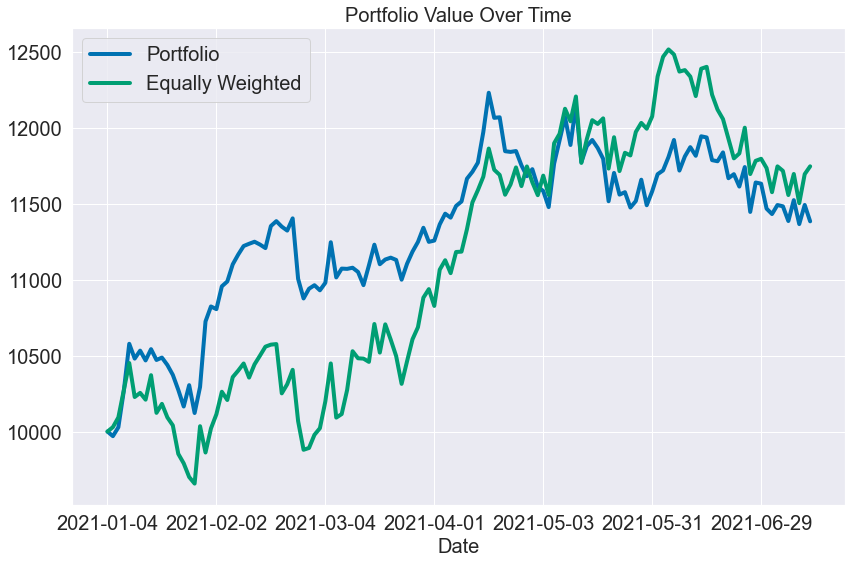

In [31]:
C = 10_000
raw_weights, portfolio_weights, out_sample = gera_portfolio(dados, 'cvar')
backtest_range = out_sample.index
out_sample_returns = out_sample.pct_change().dropna()



if "BTC-USD" in out_sample_returns.columns and len(portfolio_weights) != 25:
  stock_proportion = 1 - portfolio_weights[-25:].sum()
  equal_stocks = np.repeat(stock_proportion/len(dados_acoes.columns), len(dados_acoes.columns))
  equal_crypto = np.repeat((1 - stock_proportion)/len(dados_cripto.columns), len(dados_cripto.columns))
  equal_weights = np.concatenate((equal_stocks, equal_crypto))
else:
  equal_weights = np.ones_like(out_sample.columns) / len(out_sample.columns)

capital = [(C, C)]

for _, row in out_sample_returns.iterrows():
  portofolio_return, equal_return = np.dot(portfolio_weights, row), np.dot(equal_weights, row)

  C_portfolio, C_equal = capital[-1][0] * (1+portofolio_return), capital[-1][1] * (1+equal_return)
  capital.append((C_portfolio, C_equal))
  

backtest_df = pd.DataFrame(capital, index=backtest_range, columns=["Portfolio", "Equally Weighted"])
backtest_df.plot()
plt.title("Portfolio Value Over Time")
plt.tight_layout()

In [34]:
portfolio_metrics(backtest_df['Portfolio'], 'cvar')

Expected annual return: 28.8%
Conditional Value at Risk: -2.45%


In [20]:
def plot_weights(raw_weights):
  new_weights = OrderedDict()
  for ticker in raw_weights:
    if raw_weights[ticker] != 0:
      new_weights[ticker] = raw_weights[ticker]

  pd.Series(new_weights).plot.barh()
  plt.title("Portfolio Composition")
  plt.xlabel("Proportion")
  plt.tight_layout()

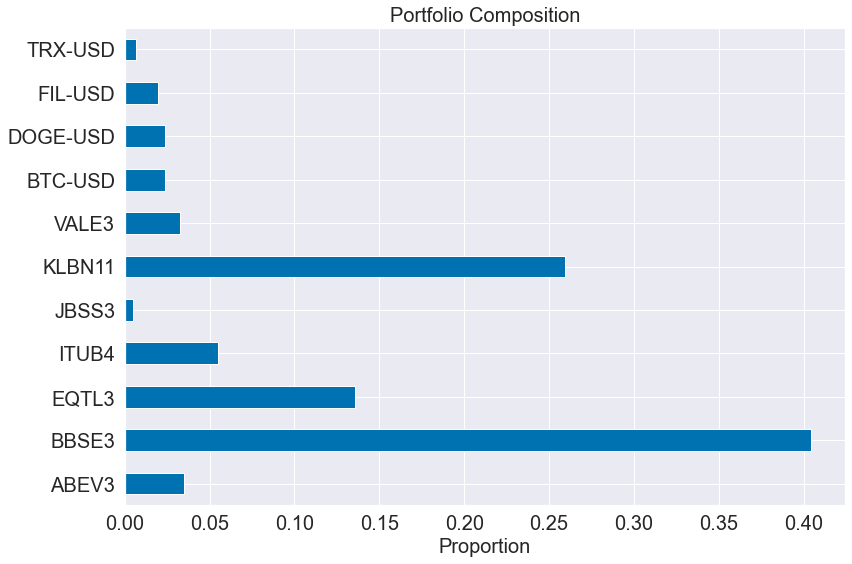

In [21]:
plot_weights(raw_weights)